# Training

## Libraries

In [1]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
from glob import glob
import os
# !pip install onlinehd
# import onlinehd

## Dataset loading

In [2]:
'''
Dataset structure:
audio/
├── train
│  ├── class
│  │   ├── 1.wav
│  │   ├── 2.wav
│  │   ├── ...
│  └── ...
'''
def load_dataset(type="train"):
    # Path to audio folder
    audio_folder = "audio/{}".format(type)
    # Extract all classes available by reading the subfolder names
    classes = sorted(os.listdir(audio_folder))
    # Extract all audio files available for each class as a separate list
    audio_files = {}
    for c in classes:
        # Get all files in the class folder
        audio_files[c] = sorted(glob(os.path.join(audio_folder, c, "*.wav")))

    print("Classes: ", classes)
    print(audio_files)
    return audio_files, classes

load_dataset("train")


Classes:  ['bell', 'glass', 'saw']
{'bell': ['audio/train/bell/1.wav', 'audio/train/bell/2.wav', 'audio/train/bell/3.wav', 'audio/train/bell/4.wav'], 'glass': ['audio/train/glass/1.wav', 'audio/train/glass/2.wav', 'audio/train/glass/3.wav', 'audio/train/glass/4.wav'], 'saw': ['audio/train/saw/1.wav', 'audio/train/saw/2.wav', 'audio/train/saw/3.wav', 'audio/train/saw/4.wav']}


({'bell': ['audio/train/bell/1.wav',
   'audio/train/bell/2.wav',
   'audio/train/bell/3.wav',
   'audio/train/bell/4.wav'],
  'glass': ['audio/train/glass/1.wav',
   'audio/train/glass/2.wav',
   'audio/train/glass/3.wav',
   'audio/train/glass/4.wav'],
  'saw': ['audio/train/saw/1.wav',
   'audio/train/saw/2.wav',
   'audio/train/saw/3.wav',
   'audio/train/saw/4.wav']},
 ['bell', 'glass', 'saw'])

## Feature extractions

In [3]:
def zcr(frame, frame_length):
    """Compute Zero Crossing Rate (ZCR)"""
    # Count the number of times the signal changes sign
    # zero_crossings = np.sum(np.abs(np.diff(np.sign(frame)))) / 2
    # return zero_crossings / frame_length
    return librosa.feature.zero_crossing_rate(frame, frame_length=frame_length)[0, 0]

def rms(frame):
    """Compute Root Mean Square (RMS)"""
    # RMS measures the average power of the signal
    # return np.sqrt(np.sum(frame**2) / len(frame))
    return np.sqrt(np.mean(frame**2))

def temporal_entropy(frame):
    """Compute Temporal Entropy"""
    # Temporal entropy measures the distribution of energy in the time domain
    hist = np.histogram(frame, bins=8, range=(np.min(frame), np.max(frame)))[0]
    prob = hist / np.sum(hist)
    prob = prob[prob > 0]  # Avoid log(0)
    return -np.sum(prob * np.log2(prob))

def compute_fft(y, frame_length, hop_length):
    """Compute the Short-Time Fourier Transform (STFT) using NumPy."""
    # Frame-based processing
    # frames = librosa.util.frame(y, frame_length=frame_length, hop_length=hop_length)
    # window = np.hanning(frame_length)  # Apply a Hanning window
    # fft_result = np.fft.rfft(frames * window[:, None], axis=0)  # Compute FFT
    # return np.abs(fft_result)  # Return the magnitude spectrum
    return librosa.stft(y, n_fft=frame_length, hop_length=hop_length, window='hann', center=False)

def spectral_centroid(S, sr):
    """Compute Spectral Centroid"""
    # Spectral centroid is the weighted mean of the frequencies
    # freqs = np.fft.rfftfreq(S.shape[0] * 2 - 1, d=1/sr)
    # magnitude = np.sum(S, axis=1)
    # centroid = np.sum(freqs * magnitude) / np.sum(magnitude)
    # return centroid
    return librosa.feature.spectral_centroid(S=S, sr=sr)

def spectral_rolloff(S, sr, roll_percent=0.85):
    """Compute Spectral Rolloff"""
    # Spectral rolloff is the frequency below which a certain percentage of the total spectral energy is contained
    # freqs = np.fft.rfftfreq(S.shape[0] * 2 - 1, d=1/sr)
    # total_energy = np.sum(S)
    # cumulative_energy = np.cumsum(S)
    # rolloff_idx = np.where(cumulative_energy >= roll_percent * total_energy)[0]
    # if len(rolloff_idx) == 0:  # Handle case where no index satisfies the condition
    #     return freqs[-1]  # Return the highest frequency
    # return freqs[rolloff_idx[0]]
    # Using librosa's built-in function for simplicity
    return librosa.feature.spectral_rolloff(S=S, sr=sr, roll_percent=roll_percent)

def spectral_flatness(S):
    """Compute Spectral Flatness"""
    # Spectral flatness is the ratio of the geometric mean to the arithmetic mean of the spectrum
    # geometric_mean = np.exp(np.mean(np.log(S + 1e-10)))  # Add small value to avoid log(0)
    # arithmetic_mean = np.mean(S)
    # return geometric_mean / arithmetic_mean
    return librosa.feature.spectral_flatness(S=S)

def band_ratio(S, sr, frame_length):
    """Compute Band Energy Ratio (low vs mid frequencies)"""
    # Band energy ratio compares the energy in different frequency bands
    # freqs = np.fft.rfftfreq(frame_length, d=1/sr)
    freqs = librosa.fft_frequencies(sr=sr, n_fft=frame_length)
    low_band = (freqs >= 100) & (freqs < 1000)
    mid_band = (freqs >= 1000) & (freqs < 4000)
    low_energy = np.sum(S[low_band, :], axis=0)
    mid_energy = np.sum(S[mid_band, :], axis=0)
    return mid_energy / (low_energy + 1e-10)
    # Add small value to avoid division by zero

In [4]:
def extract_audio_features(file_path, sr, frame_length=2048, hop_length=512):
    """Extract material sound features compatible with HDC requirements"""
    
    # Load audio with optimal parameters for material sounds
    y, sr = librosa.load(file_path, sr=sr, duration=5.0)  # 16kHz sampling
    
    # Frame-based processing
    frames = librosa.util.frame(y, frame_length=frame_length, hop_length=hop_length)
    num_frames = frames.shape[1]
    
    # Initialize feature arrays with zeros
    feature_names = ['zcr', 'rms', 'temporal_entropy', 'spectral_centroid', 'spectral_rolloff', 'spectral_flatness', 'band_ratio']
    features = {name: np.zeros(num_frames) for name in feature_names}

    # Time-domain features
    for i in range(num_frames):
        frame = frames[:, i]
        features['zcr'][i] = zcr(frame, frame_length)
        features['rms'][i] = rms(frame)
        features['temporal_entropy'][i] = temporal_entropy(frame)

    # Frequency-domain features
    S = np.abs(librosa.stft(y, n_fft=frame_length, hop_length=hop_length))
    features['spectral_centroid'] = spectral_centroid(S, sr)
    features['spectral_rolloff'] = spectral_rolloff(S, sr)
    features['spectral_flatness'] = spectral_flatness(S)

    # Band energy ratio (low vs mid frequencies)
    features['band_ratio'] = band_ratio(S, sr, frame_length)

    # Aggregate statistics for HDC encoding
    feature_vector = [
        np.mean(features['zcr']), np.std(features['zcr']),
        np.mean(features['rms']), np.max(features['rms']),
        np.mean(features['temporal_entropy']),
        np.mean(features['spectral_centroid']),
        np.mean(features['spectral_rolloff']),
        np.mean(features['spectral_flatness']),
        np.mean(features['band_ratio'])
    ]
    
    return feature_vector

## Data preprocessing

Classes:  ['bell', 'glass', 'saw']
{'bell': ['audio/train/bell/1.wav', 'audio/train/bell/2.wav', 'audio/train/bell/3.wav', 'audio/train/bell/4.wav'], 'glass': ['audio/train/glass/1.wav', 'audio/train/glass/2.wav', 'audio/train/glass/3.wav', 'audio/train/glass/4.wav'], 'saw': ['audio/train/saw/1.wav', 'audio/train/saw/2.wav', 'audio/train/saw/3.wav', 'audio/train/saw/4.wav']}


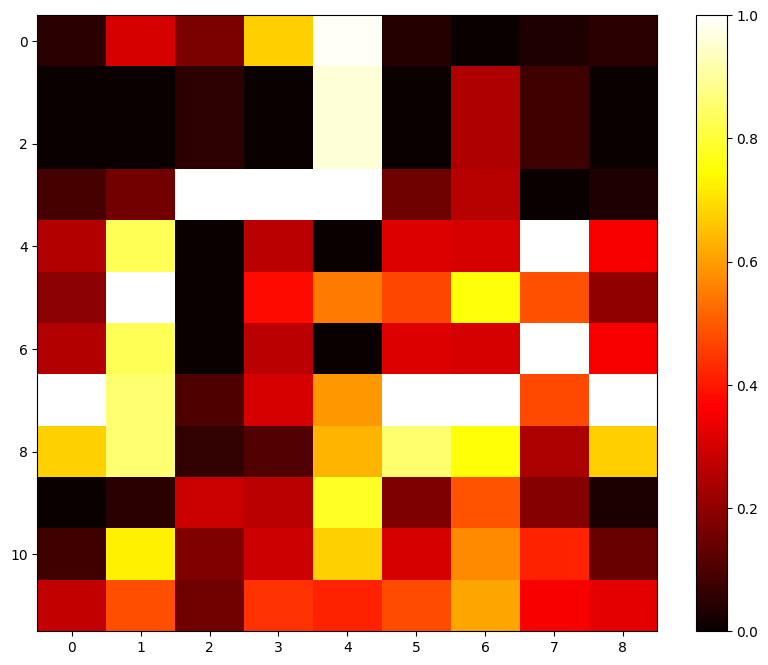

In [ ]:
# # Extract features for all audio files and encode them
# dataset = []
# labels = []

# audio_files, classes = load_dataset("train")


# for label_idx, class_name in enumerate(classes):
#     for file_path in audio_files[class_name]:
#         # Extract features
#         feature_vector = extract_audio_features(file_path, sr=8000)
#         dataset.append(feature_vector)
#         labels.append(label_idx)

# # normailize the dataset where each column is a feature
# dataset = np.array(dataset) 
# dataset = (dataset - np.min(dataset, axis=0)) / (np.max(dataset, axis=0) - np.min(dataset, axis=0))

# # visualize the dataset in heatmap
# plt.figure(figsize=(10, 8))
# plt.imshow(dataset, aspect='auto', cmap='hot')
# plt.colorbar()

## HDC operations

In [95]:
D = 10000  # Hypervector dimensionality
LEVELS = 256
np.random.seed(42)

# --- Feature Setup ---
feature_names = [
    'zcr_mean', 'zcr_std', 'rms_mean', 'rms_max',
    'entropy_mean', 'spectral_centroid_mean', 'spectral_rolloff_mean',
    'spectral_flatness_mean', 'band_ratio_mean'
]

# Selectively chosen important feature pairs
important_pairs = [
    ('zcr_mean', 'entropy_mean'),
    ('rms_mean', 'spectral_rolloff_mean'),
    ('spectral_flatness_mean', 'spectral_centroid_mean'),
    ('rms_max', 'band_ratio_mean')
]

# --- 1. Feature name codebook (via permutation) ---
def generate_feature_codebook(feature_names, D):
    base = np.random.randint(0, 2, D, dtype=np.uint8)
    return {name: np.roll(base, i + 1) for i, name in enumerate(feature_names)}

# --- 2. Pre-generate value level hypervectors ---
def generate_value_level_hvs(levels, D):
    level_hvs = []
    for level in range(levels):
        hv = np.zeros(D, dtype=np.uint8)
        if level > 0:
            n_bits = level * D // levels
            indices = np.random.choice(D, n_bits, replace=False)
            hv[indices] = 1
        level_hvs.append(hv)
    return level_hvs

# --- 3. Map value to nearest level HV ---
def get_value_hv(value, level_hvs):
    level = min(LEVELS - 1, max(0, int(value * LEVELS)))
    return level_hvs[level]

# --- 4. Encode single audio feature vector ---
def encode_feature_vector(features, codebook, level_hvs, D):
    assert len(features) == len(codebook)
    
    feature_dict = dict(zip(codebook.keys(), features))
    hvs = []

    # Step 1: Encode individual features (key ⊙ value)
    for name, value in feature_dict.items():
        feat_hv = np.bitwise_xor(codebook[name], get_value_hv(value, level_hvs))
        hvs.append(feat_hv.astype(np.int16))

    # Step 2: Encode selected feature-pair interactions (bound pair HVs)
    for f1, f2 in important_pairs:
        hv1 = np.bitwise_xor(codebook[f1], get_value_hv(feature_dict[f1], level_hvs))
        hv2 = np.bitwise_xor(codebook[f2], get_value_hv(feature_dict[f2], level_hvs))
        pair_hv = np.bitwise_xor(hv1, hv2)
        hvs.append(pair_hv.astype(np.int16))

    # Optional: visualize before bundling
    # plt.figure(figsize=(10, 8))
    # plt.imshow(hvs, aspect='auto', cmap='hot', vmin=0, vmax=1)
    # plt.colorbar()
    
    # Step 3: Final bundling (majority vote)
    sum_hv = np.sum(hvs, axis=0)
    threshold = len(hvs) // 2
    final_hv = (sum_hv >= threshold).astype(np.uint8)

    return final_hv

#######

dataset = []
labels = []

audio_files, classes = load_dataset("train")

for label_idx, class_name in enumerate(classes):
    for file_path in audio_files[class_name]:
        features = extract_audio_features(file_path, sr=8000)
        dataset.append(features)
        labels.append(label_idx)

# Normalize feature-wise (0–1 scaling)
dataset = np.array(dataset)
dataset = (dataset - dataset.min(axis=0)) / (dataset.max(axis=0) - dataset.min(axis=0))

# --- Prepare encoding ---
codebook = generate_feature_codebook(feature_names, D)
value_level_hvs = generate_value_level_hvs(LEVELS, D)

vectors = []

# encoded_hv = encode_feature_vector(dataset[0], codebook, value_level_hvs, D)

for features in dataset:
    encoded_hv = encode_feature_vector(features, codebook, value_level_hvs, D)
    vectors.append(encoded_hv)

vectors = np.array(vectors)
labels = np.array(labels)


Classes:  ['bell', 'glass', 'saw']
{'bell': ['audio/train/bell/1.wav', 'audio/train/bell/2.wav', 'audio/train/bell/3.wav', 'audio/train/bell/4.wav'], 'glass': ['audio/train/glass/1.wav', 'audio/train/glass/2.wav', 'audio/train/glass/3.wav', 'audio/train/glass/4.wav'], 'saw': ['audio/train/saw/1.wav', 'audio/train/saw/2.wav', 'audio/train/saw/3.wav', 'audio/train/saw/4.wav']}


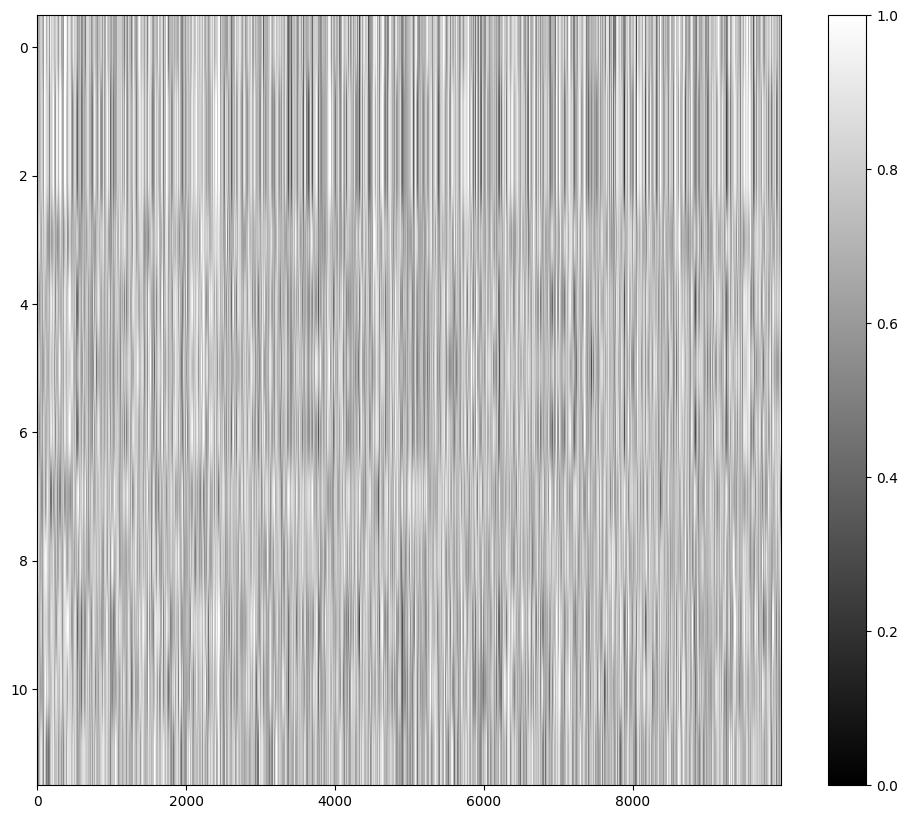

In [96]:
# make array of all values in the codebook
codebook_values = np.array(list(codebook.values()))
plt.figure(figsize=(12, 10))
plt.imshow(vectors, aspect='auto', cmap=plt.cm.gray) #, vmin=0, vmax=1)
plt.colorbar()


## Model training

In [ ]:
def train_hd_classifier(dataset, labels, codebook, D=10000, num_classes=None, epochs=5):
    """
    dataset: list of feature vectors (N x 9)
    labels: corresponding class labels (N)
    codebook: feature name -> hypervector
    """
    if num_classes is None:
        num_classes = len(set(labels))
    
    # Initialize real-valued class hypervectors
    real_class_hvs = np.zeros((num_classes, D), dtype=np.int16)
    
    for epoch in range(epochs):
        for x, y_true in zip(dataset, labels):
            query_hv = encode_feature_vector(x, codebook, D)
            
            # Predict by comparing to binarized class HVs
            predictions = [np.sum(query_hv != (real_class_hvs[c] >= 0)) for c in range(num_classes)]
            y_pred = np.argmin(predictions)

            if y_pred != y_true:
                # OnlineHD-style update
                real_class_hvs[y_true] += query_hv
                real_class_hvs[y_pred] -= query_hv

        # Optional: shuffle data each epoch to avoid bias
        shuffled = list(zip(dataset, labels))
        np.random.shuffle(shuffled)
        dataset[:], labels[:] = zip(*shuffled)

    # Final binarization
    binarized_class_hvs = (real_class_hvs >= 0).astype(np.uint8)
    return binarized_class_hvs

def predict_hd(query_hv, class_hvs):
    """
    Predict label for a query hypervector using Hamming distance.
    """
    distances = [np.sum(query_hv != class_hv) for class_hv in class_hvs]
    return np.argmin(distances)

def evaluate_hd(dataset, labels, class_hvs, codebook, D=10000):
    correct = 0
    for x, y_true in zip(dataset, labels):
        query_hv = encode_feature_vector(x, codebook, D)
        y_pred = predict_hd(query_hv, class_hvs)
        if y_pred == y_true:
            correct += 1
    return correct / len(labels)

# Step 2: Train
class_hvs = train_hd_classifier(dataset, labels, codebook, D, epochs=10)

# Step 3: Evaluate
acc = evaluate_hd(dataset, labels, class_hvs, codebook, D)
print(f"Training accuracy: {acc * 100:.2f}%")


## Export model weights

# Inference

## Load sample

## Extract features

## HDC operations

## Model inference

In [ ]:
# query HV is compared to all the class HVs in the item memory using Hamming distance